# L-Systems and Spectral Filtering in Ableton Live

### Written by Brian Tice
### University of California, San Diego

This python notebook is used to evaluate the use of L-Systems as a source for spectral filter parameters in a musical collaboration with Tim Gmeiner. We explore the idea that Lindenmayer systems, or L-Systems are used to generate particular sequences of numbers that are then sent to a Max patch written for Ableton Live. Attention to a human centered approach is paramount because we didn't want the algorithmic approach to impede on the human qualities of the music. In other words generative algorithms are merely a tool to add color to the music and are not used to generate music.

Within the context of our musical collaboration, we created an audio patch that utilizes L-systems to define the parameters of a filter applied to the drums. In particular, frequency band levels of a 256 band spectral filter are defined by the results of an L-System. The patch takes integer text input generated from an L-system, and then maps it to spectral band amplitudes of the filter. A visual representation is also generated in the patch. There is also the ability to live code new L-systems, or any sequence for that matter, and send them via an OSC connection to the patch. Lastly, there exist preset L-System results that can be applied via a knob and three preset buttons. Enjoy and please send any feedback to: btice@ucsd.edu

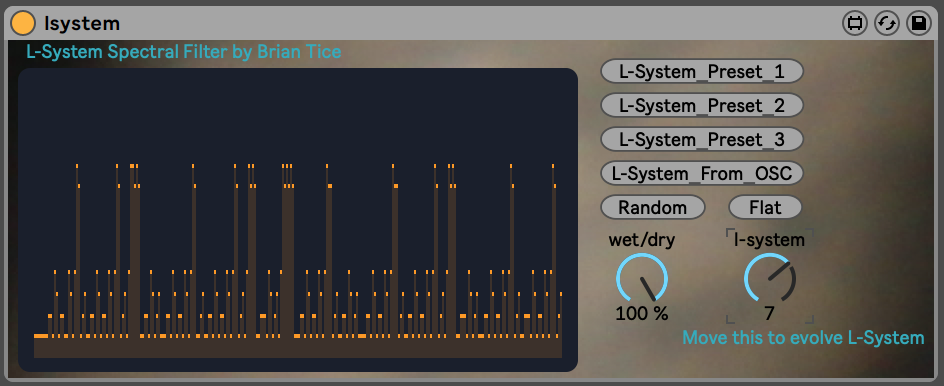

Credit must be given to CNMAT for their OSC max objects as well as to Zack Settel and Cort Lippe for their paper, "Real-Time Musical Applications using FFT-based Resynthesis", that inspired the Spectral Filter Max for Live patch that we modified for our work. 

## L-Systems  

The L-System works with a set of letters, A-L. The function sets rules and the number of iterations, as well as the axiom. Next, the output string is remapped to a series of integer values with a range of 0-127 because this is the range of a given freqency band level in the filter. In total, 256 integers are calulated in the sequence because this is the number of bands in the spectral filter. The mapping is currently linear between alphabet and integer representation, and is defined to be the following:

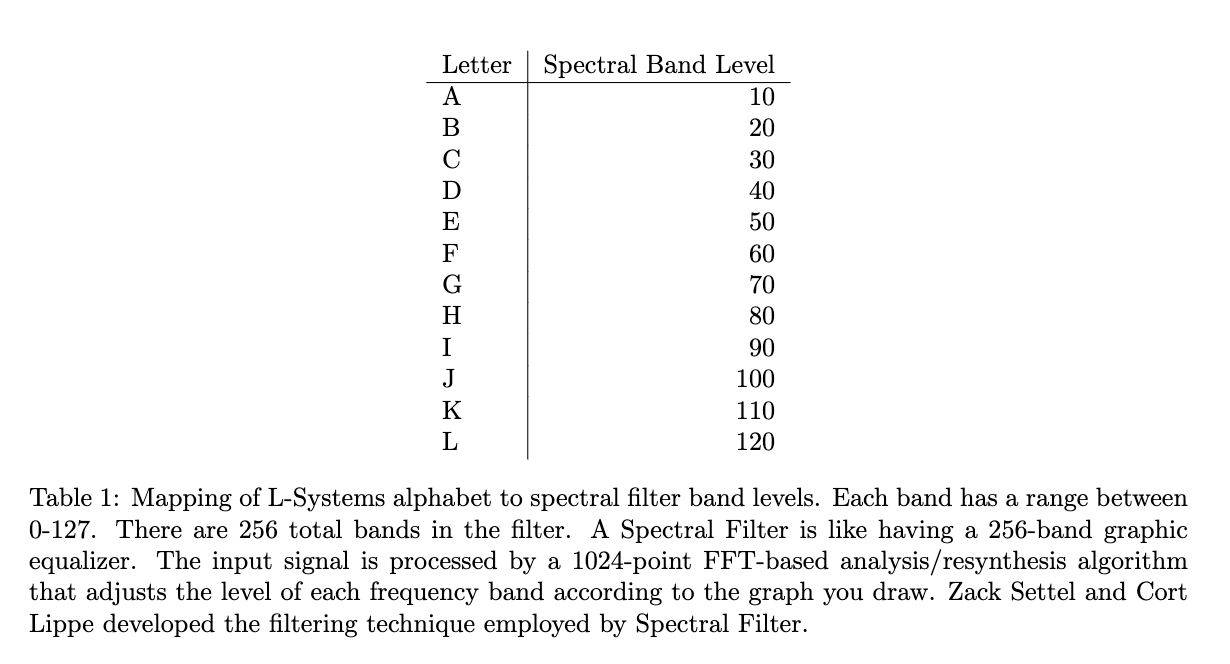

The code is written to be run sequentially in the notebook. First an L-System function is defined that allows for the creation of an output string that consists of capital letters A-L. Next, three different L-Systems are generated and are hardcoded into the plugin. They are mapped to the buttons: lsystem, lsystem_two, and lsystem_three. When the user clicks these buttons, the integer representation of these L-Systems is loaded into the filter. The overall effect of this is a different equalization setting for the master track of the drums. Lastly, there is the option to live code L-Systems in the Python notebook. The integer representation of the L-System is sent via an OSC connection to Ableton Live, where the settings are updated if the user clicks on the lsystem_realtime button.

In the future this approach could be adapted to vary parameters of other effects. Sequences other than L-Systems could be explored.

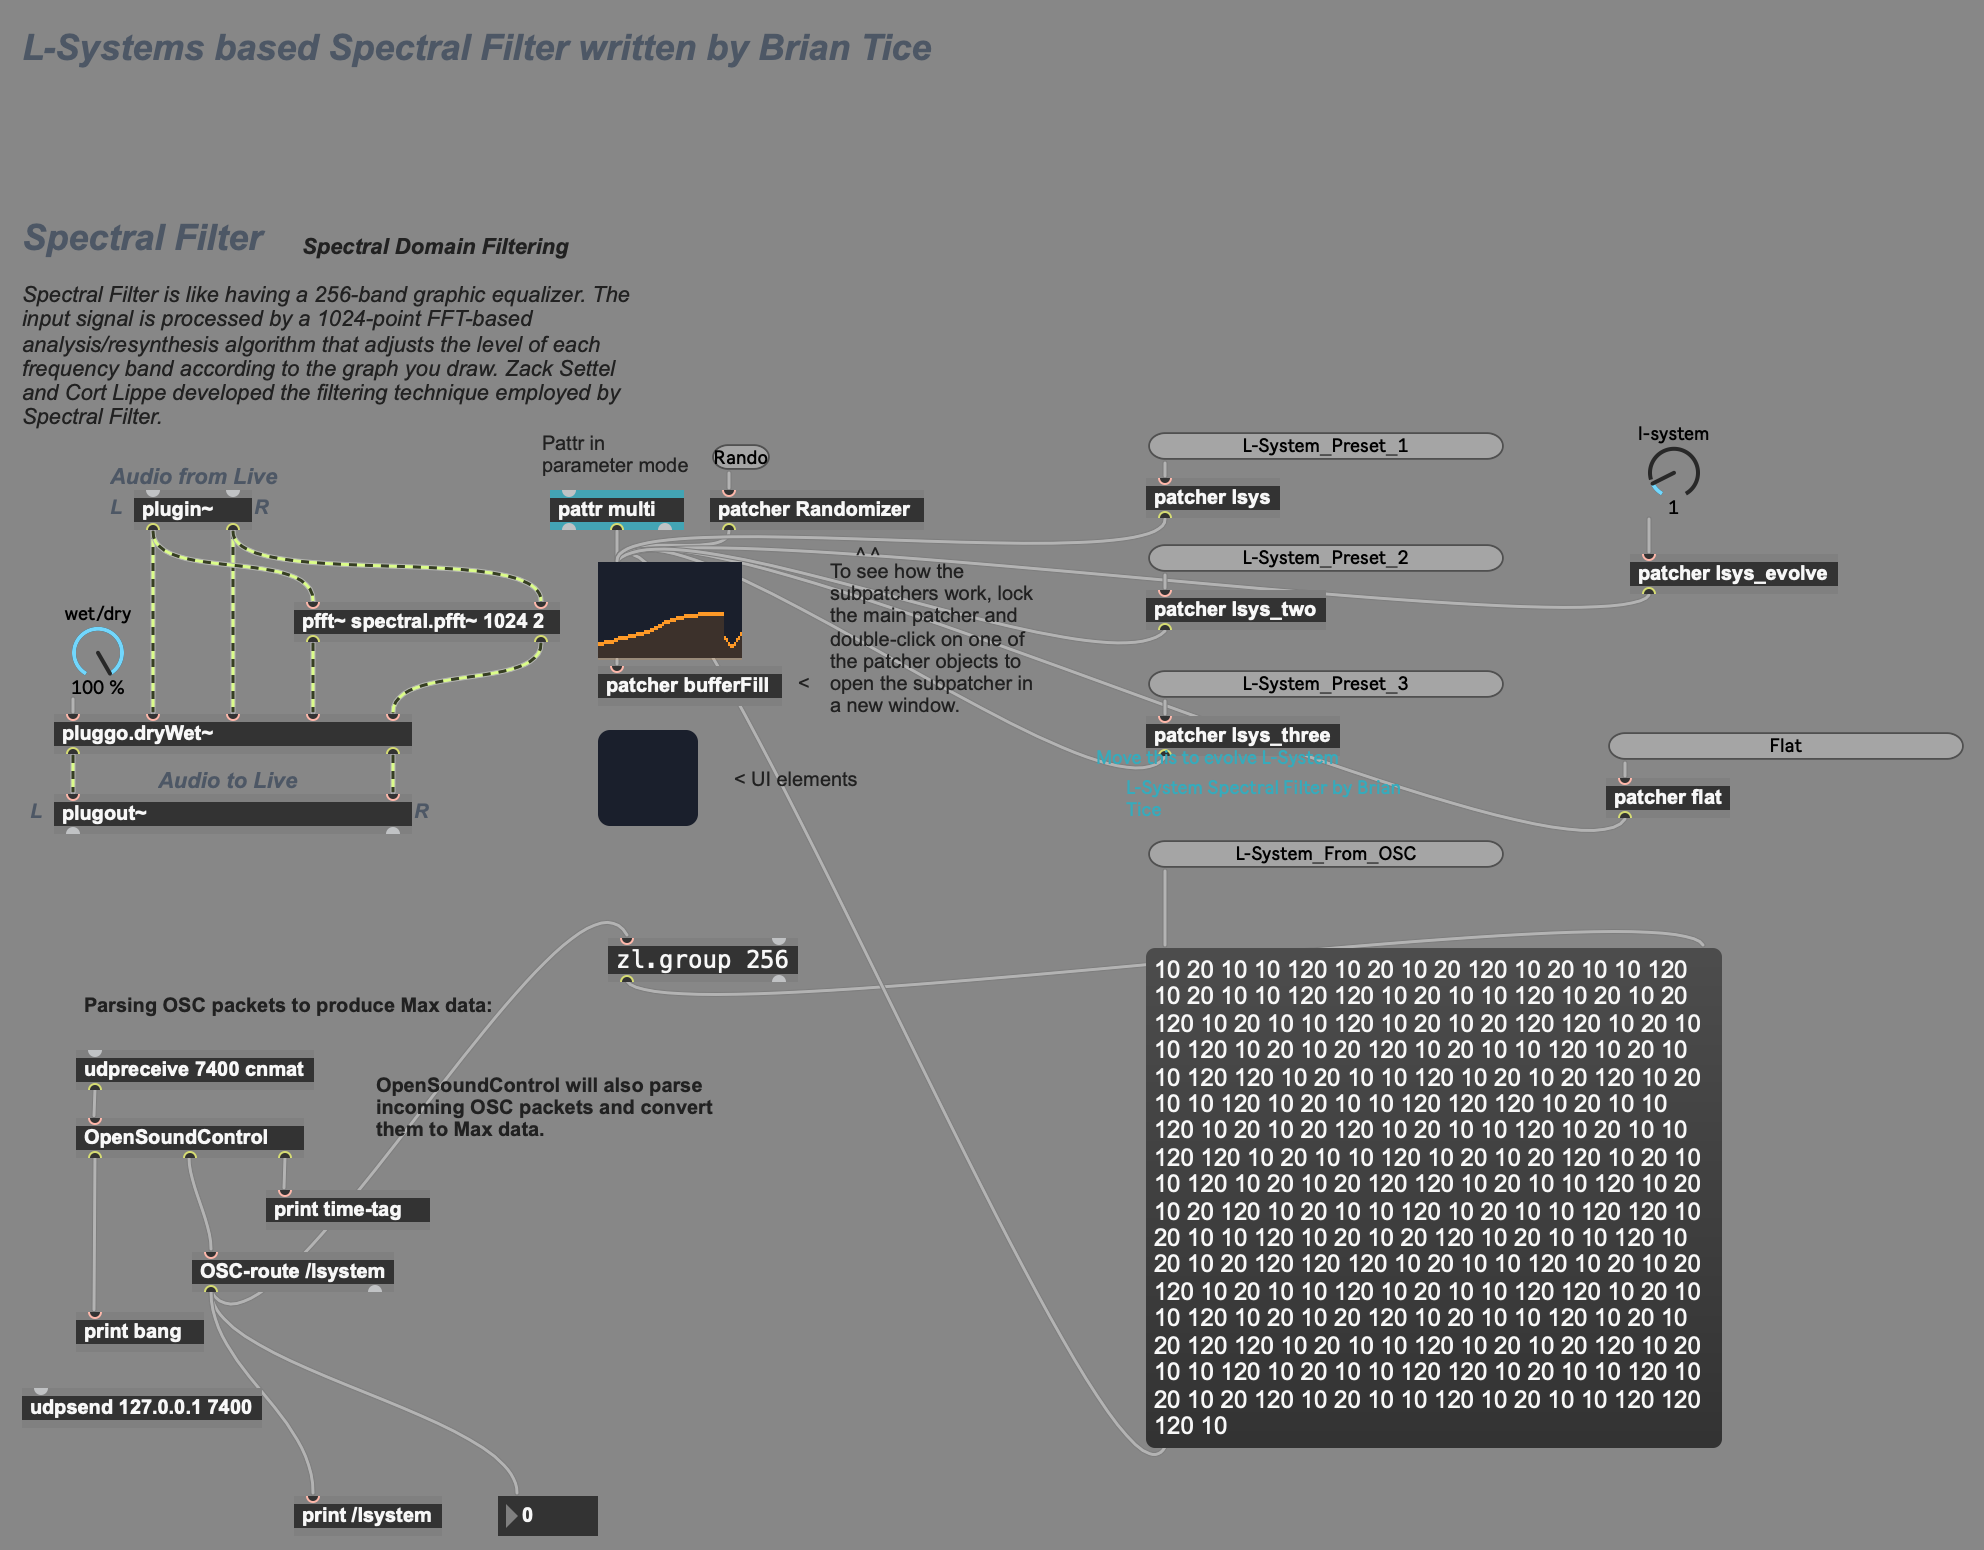

In [1]:
# Pythonosc library module that does not require the sender and receiver of the message to be directly connected 
from pythonosc import dispatcher
# Pythonosc library module that imports a server capable of receiving messages in OSC format 
from pythonosc import osc_server
import time

In [2]:
def lsystem(axioms, rules, iterations):
    #    We iterate through our method required numbers of time.
    for _ in range(iterations):
        #    Our newly created axioms from this iteration.
        newAxioms = ''

        #    This is your code, but with renamed variables, for clearer code.
        for axiom in axioms:
            if axiom in rules:
                newAxioms += rules[axiom]
            else:
                newAxioms += axiom
        #    You will need to iterate through your newAxioms next time, so...
        #    We transfer newAxioms, to axioms that is being iterated on, in the for loop.
        axioms = newAxioms
    return axioms

In [3]:
rules = { "A" : "AEF" , "B" : "LHG", "C":"ABC", "D":"DIH"}
print(lsystem('12', rules, 0))
# outputs : 'AB'

12


In [4]:
print(lsystem('AB', rules, 1))
# outputs : 'ABABBB'

AEFLHG


In [5]:
print(lsystem('AB', rules, 2))
# outputs : 'ABABBBABABBBBBBBBB'

AEFEFLHG


In [8]:
# Note, run this code to generate a new L-system and send the integer representation
# to ableton live via and OSC message. Only the first 256 integers are sent.


##rules_three = { "A" : "ACD" , "C" : "AAKL", "C":"ABC", "D":"DIH"}
##rules_three = { "A" : "ABDC" , "C" : "ABL", "C":"ABC", "D":"DIH"}
##rules_three = { "B" : "ABDC" , "C" : "ABL", "C":"ABC", "D":"DIH"}
##rules_three = { "B" : "BBDC" , "C" : "ABL", "C":"ABC", "D":"DIH"}
##rules_three = { "B" : "ABBDC" , "C" : "ABL", "C":"ABC", "D":"DIH"}
##rules_three = { "B" : "ABBADC" , "C" : "ABL", "C":"ABC", "D":"DIH"}
##rules_three = { "B" : "ABBABDC" , "C" : "ABL", "C":"ABC", "D":"DIH"}
##rules_three = { "A" : "ABBABABDC" , "B" : "ABL", "C":"ABC", "D":"DIH"}
##rules_three = { "A" : "ABBABABDC" , "B" : "ABAL", "C":"ABC", "D":"DIH"}
rules_three = { "A" : "ABC" , "B" : "AL", "C":"AC", "D":"DIH"}

system_three = lsystem('ABC', rules_three, 6)

print(system_three)

# Map letters to numbers between 1 and 128

data_three = []

for i in range(256):
    if (system_three[i] ==   'A'):
        data_three.append(10)
    elif (system_three[i] == 'B'):
        data_three.append(20)
    elif (system_three[i] == 'C'):
        data_three.append(30)
    elif (system_three[i] == 'D'):
        data_three.append(40)
    elif (system_three[i] == 'E'):
        data_three.append(50)
    elif (system_three[i] == 'F'):
        data_three.append(60)
    elif (system_three[i] == 'G'):
        data_three.append(70)
    elif (system_three[i] == 'H'):
        data_three.append(80)
    elif (system_three[i] == 'I'):
        data_three.append(90)
    elif (system_three[i] == 'J'):
        data_three.append(100)
    elif (system_three[i] == 'K'):
        data_three.append(110)
    elif (system_three[i] == 'L'):
        data_three.append(120)
        

#print(data_three)

print(*data_three, sep=' ')
#print()
flat = []
for i in range(256):
    flat.append(64)

#print(*flat, sep=' ')
print(len(data_three))

from pythonosc.udp_client import SimpleUDPClient

ip = "127.0.0.1"
port = 7400

client = SimpleUDPClient(ip, port)  # Create client


# send an entire list of the l-system to MAX

#client.send_message("/lsystem", 10)   # Send float message
#client.send_message("/some/address", [1, 2., "yes"])  # Send message with int, float and string

for j in range(256):
    client.send_message("/lsystem", int(data_three[j]))   # Send float message
    #time.sleep(0.03)

ABCALACABCLABCACABCALACLABCALACABCACABCALACABCLABCACLABCALACABCLABCACABCALACABCACABCALACABCLABCACABCALACLABCALACABCACLABCALACABCLABCACABCALACLABCALACABCACABCALACABCLABCACABCALACABCACABCALACABCLABCACABCALACLABCALACABCACABCALACABCLABCACLABCALACABCLABCACABCALACABCACLABCALACABCLABCACABCALACLABCALACABCACABCALACABCLABCACLABCALACABCLABCACABCALACABCACABCALACABCLABCACABCALACLABCALACABCACABCALACABCLABCACABCALACABCAC
10 20 30 10 120 10 30 10 20 30 120 10 20 30 10 30 10 20 30 10 120 10 30 120 10 20 30 10 120 10 30 10 20 30 10 30 10 20 30 10 120 10 30 10 20 30 120 10 20 30 10 30 120 10 20 30 10 120 10 30 10 20 30 120 10 20 30 10 30 10 20 30 10 120 10 30 10 20 30 10 30 10 20 30 10 120 10 30 10 20 30 120 10 20 30 10 30 10 20 30 10 120 10 30 120 10 20 30 10 120 10 30 10 20 30 10 30 120 10 20 30 10 120 10 30 10 20 30 120 10 20 30 10 30 10 20 30 10 120 10 30 120 10 20 30 10 120 10 30 10 20 30 10 30 10 20 30 10 120 10 30 10 20 30 120 10 20 30 10 30 10 20 30 10 120 10 30 10 20 30 10 30 10 20 30 10 120 10 